In [8]:
import matplotlib.pyplot as plt

import sys

sys.path.append("./")
sys.path.append("../../blackjax")

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 19

import jax
import blackjax
import numpy as np
import jax.numpy as jnp

def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

In [9]:
# logdensity_fn = lambda x: -0.5 * jnp.sum(jnp.square(x))

# b_hbar_omega = 15.8
# m_omega_over_hbar = 0.03
beta_hbar_omega = 15.8
m_omega_over_hbar = 0.03
m = 1.0
hbar = 1.0
omega = (m_omega_over_hbar * hbar) / m
beta = (beta_hbar_omega / (hbar * omega))


def V(xi):
    return 0.5 * m * (omega ** 2) * (jnp.linalg.norm(xi) ** 2)

@jax.jit
# -beta V_{eff}
# x.shape = (P,3)
def logdensity_fn(x):
    P = x.shape[0] - 1 # number of beads
    term1 = (m*P)/(2*(beta**2)*(hbar**2))*jnp.sum(jnp.array(
        [jnp.linalg.norm(x[i] - x[i+1])**2 for i in range(P)]))
    term2 = (V(x[0]) + V(x[-1]))/(2*P)
    term3 = jnp.sum(jax.vmap(V,in_axes=0)(x)[1:-1])/P

    # return -jnp.log(term1 + term2 + term3)
    return -beta*(term1 + term2 + term3)

sq = lambda x: x.dot(x)

@jax.jit
def logdensity_fn_fast(x):
    P = x.shape[0] - 1 # number of beads
    term1 = (m*P)/(2*(beta**2)*(hbar**2))*jnp.sum(jnp.array(
    jax.vmap(sq)(x[:-1,:]-x[1:,:]) ))
    term2 = (V(x[0]) + V(x[-1]))/(2*P)
    term3 = jnp.sum(jax.vmap(V,in_axes=0)(x)[1:-1])/P

    # return -jnp.log(term1 + term2 + term3)
    return -beta*(term1 + term2 + term3)


arr = jax.random.normal(jax.random.PRNGKey(0), (10, 3))
print(logdensity_fn_fast(arr))
print(logdensity_fn(arr))



-1.054393
-1.054393


In [10]:
num_steps = 200000
def transform(state, info):
    return ((state.position[-1] - state.position[0]))[0]

rng_key = jax.random.PRNGKey(0)

sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn_fast,
    num_steps=num_steps,
    initial_position=jax.random.normal(sample_key, (400,3)),
    key=rng_key,
    transform=transform,
)
samples.mean()

Array(0.01893452, dtype=float32)

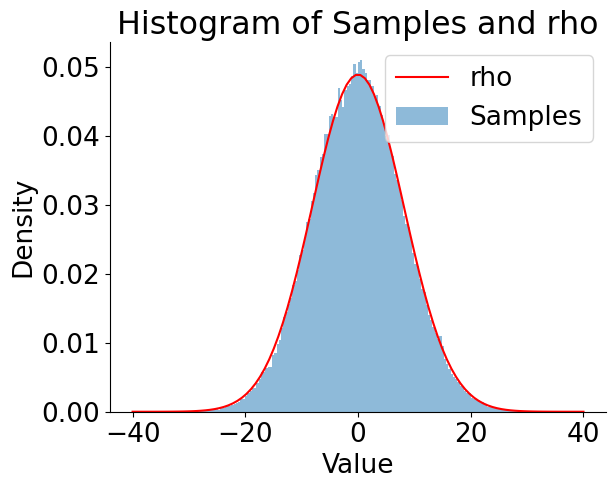

In [11]:
def rho(x):
    return jnp.sqrt((m*omega)/(4*jnp.pi*hbar*jnp.tanh(beta*hbar*omega / 2)))*jnp.exp((-m*omega*(x**2))/(4*hbar*jnp.tanh(beta*hbar*omega / 2)))

x = np.linspace(-40, 40, 100)
plt.plot(x, rho(x), color='red', label='rho')
plt.hist(samples, bins=180, density=True, alpha=0.5, label='Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Samples and rho')
plt.legend()
plt.show()


# plt.hist(samples, bins=60,density=True)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of Samples')
# plt.show()

In [63]:
beta_hbar_omega = 15.8
m_omega_over_hbar = 0.03
m = 1.0
hbar = 1.0
omega = (m_omega_over_hbar * hbar) / m
beta = (beta_hbar_omega / (hbar * omega))

def mod_index(arr, i):
    return arr[i % (arr.shape[0])]

@jax.jit
def logdensity_fn(x):
    P = x.shape[0] # number of beads
    term1 = (m*P)/(2*(beta**2)*(hbar**2))*jnp.sum(jnp.array(
        [jnp.linalg.norm(mod_index(x, i) - mod_index(x,i+1))**2 for i in range(P)]))
    term2 = jnp.sum(jax.vmap(V,in_axes=0)(x))/P

    # return -jnp.log(term1 + term2 + term3)
    return -beta*(term1 + term2)


num_steps = 100000
def transform(state, info):
    x = state.position
    P = x.shape[0]
    return (1/P)*jnp.sum(jnp.array([(1/2)*mod_index(x, i)*mod_index(jax.grad(V)(x),i) + V(mod_index(x, i)) for i in range(P)]))

rng_key = jax.random.PRNGKey(0)

sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position=jax.random.normal(sample_key, (40,1)),
    key=rng_key,
    transform=transform,
    # desired_energy_variance=0.0005
)
samples.mean()


Array(0.01447558, dtype=float32)

/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_10101/2441073857.py:2: RuntimeWarning: Mean of empty slice.
  y = [(samples[:i].mean()) / (hbar * omega / 2) for i in range( num_steps)]
/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


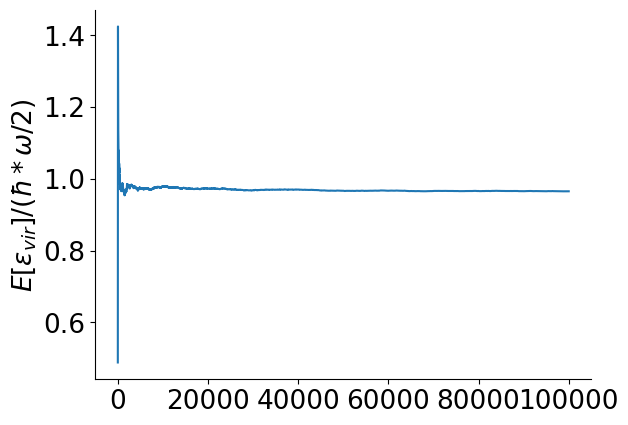

In [72]:
samples = np.array(samples)
y = [(samples[:i].mean()) / (hbar * omega / 2) for i in range( num_steps)]
plt.ylabel('$E[\epsilon_{vir}] / (\hbar * \omega / 2)$')
plt.plot(y)

In [ ]:
# 
samples[:].mean() / (hbar * omega /2)


# def V(r,t,beta):
#     term1 = 0.5*m*(omega**2)*sqnorm(r[1:]-r[:-1])
#     term2 = (1/(2*P))*(U(r[0]) + U(r[-1]))
#     term3 = (1/P)*jnp.sum(jax.vmap(U)(r[1:-1]))
    
#     term4 = (1/(2*beta))*(K @ Minv @ K + jnp.log(jnp.linalg.det(M)))
#     return term1 + term2 + term3 + term4


0.9650385628143947

In [256]:
import jax
import jax.numpy as jnp

beta_hbar_omega = 15.8
m_omega_over_hbar = 0.03
m = 1.0
hbar = 1.0
omega = (m_omega_over_hbar * hbar) / m
beta = (beta_hbar_omega / (hbar * omega))
im = 0 + 1j

U = lambda x : 0.5*m*(omega**2)*(x**2)

def make_M_Minv_K(P, t, seed):
    tau_c = t - ((beta * hbar * im) / 2)
    r = jax.random.uniform(jax.random.PRNGKey(seed), shape=(P+1,))

    alpha = (m*P*beta)/(4*(jnp.abs(tau_c)**2))
    gamma = (m*P*t)/(hbar * (jnp.abs(tau_c)**2)) 

    M = (jnp.diag(2*alpha  + (beta / (4*P))*jax.vmap(jax.grad(jax.grad(U)))(r[1:-1])) ) - alpha * jnp.diag(jnp.ones(P-2),k=1) - alpha * jnp.diag(jnp.ones(P-2),k=-1)
    # M = jnp.diag(jnp.ones((P-1,)))

    Minv = jnp.linalg.inv(M)

    K = gamma * (2*r[1:-1] - r[:-2] - r[2:]) - (t * jax.vmap(jax.grad(U))(r[1:-1]))/(P*hbar)

    return M, Minv, K, alpha, gamma, r

def run_simulation(P, t, seed=0):
    
    M,Minv, K, alpha, gamma, r = make_M_Minv_K(P, t, seed=seed)
    # K = jnp.ones((P-1,))

    # print(K @ Minv @ K, "foo")

    sqnorm = lambda x: x.dot(x)

    def log_f(s):
        term1 = (alpha / 2) * (sqnorm(s[1:] - s[:-1]) + (  (s[0]**2) + (s[-1]**2) ))
        term2 = (beta / (2*P)) * jnp.sum(jax.vmap(U)(r[1:-1] + s/2) + jax.vmap(U)(r[1:-1] - s/2))
        # term3 = P*jnp.log((m*P)/(2*jnp.pi*jnp.abs(tau_c)*hbar) )
        return  -(term1 + term2)

    def xi(s):
        # ranges wrong! todo
        term1 = gamma * ((r[2:-1] - r[1:-2]).dot(s[1:] - s[:-1])  + (r[1] - r[0])*s[0] + (r[-1] - r[-2])*s[-1] )
        term2 = -(t/(P*hbar))*jnp.sum(jax.vmap(U)(r[1:-1] + s/2) - jax.vmap(U)(r[1:-1] - s/2)  )
        return term1 + term2


    def analytic_solution(l):


        # factor0 = ((m*P)/(2*jnp.pi*jnp.abs(tau_c)*hbar))**P
        # factor1 = np.exp(-((beta*m*(omega**2))/(2*P))*sqnorm(r[1:-1]))
        # factor2 = np.sqrt(((2*jnp.pi)**(P-1))/(jnp.linalg.det(M)))
        factor3 = np.log(np.sqrt(1/(2*np.pi))*jnp.sqrt(1/(K @ Minv @ K)))
        factor4 = (-(l**2) / (2*(K @ Minv @ K))  )
        
        
        # Z = factor0*factor1*factor2
        p_lam = np.exp(factor3 + factor4)
        
        # print(factor0, "0")
        # print(factor1, "1")
        # print(factor2, "2")
        print(factor3, "3")
        print(factor4, "4")
        # print(l,"l", (K @ Minv @ K))
        # print("variance: ", (K @ Minv @ K))

        # return (1/jnp.sqrt(2*jnp.pi*(K @ Minv @ K))) * jnp.exp(-(l**2) / (2*(K @ Minv @ K)))

        return p_lam
    
    # def analytic_solution_log_space(l):
    #     # factor1 = P*jnp.log((m*P)/(2*jnp.pi*jnp.abs(tau_c)*hbar))
    #     # factor2 = 0.5*((P-2)*jnp.log(  ((2*jnp.pi)) ) - jnp.log( (jnp.linalg.det(M))) )
    #     factor3 = jnp.log(jnp.sqrt(1/(K @ Minv @ K)))
    #     # factor4 = (-(l**2) / (2*(K @ Minv @ K)) - ((beta*m*(omega**2))/(2*P))*sqnorm(r[1:-1])  )
    #     factor4 = (-(l**2) / (2*(K @ Minv @ K))  )
    #     return factor3 + factor4
    #     # print(factor1)
    #     # print(factor2)
    #     # print(factor3)
    #     # print(factor4)
    #     # print("variance: ", (K @ Minv @ K))

    #     # normalization = factor1 - ((beta*m*omega**2)/(2*P))*jnp.sum(jnp.square(r[1:-1])) + factor2

    #     # return (1/jnp.sqrt(2*jnp.pi*(K @ Minv @ K))) * jnp.exp(-(l**2) / (2*(K @ Minv @ K)))

    #     # return jnp.exp(factor1+factor2+factor3+factor4 - normalization)

    def analytic_simple(l):
        return jax.scipy.stats.norm.pdf(loc=0, scale=jnp.sqrt(K @ Minv @ K), x=l)

    return log_f, xi, analytic_solution



Time taken:  3.317100763320923
-2.5413456 3
[-6.17260218e+00 -5.92163849e+00 -5.67588282e+00 -5.43533516e+00
 -5.19999647e+00 -4.96986532e+00 -4.74494314e+00 -4.52522850e+00
 -4.31072235e+00 -4.10142469e+00 -3.89733505e+00 -3.69845343e+00
 -3.50478005e+00 -3.31631517e+00 -3.13305855e+00 -2.95500994e+00
 -2.78216958e+00 -2.61453748e+00 -2.45211363e+00 -2.29489803e+00
 -2.14289069e+00 -1.99609160e+00 -1.85450077e+00 -1.71811795e+00
 -1.58694351e+00 -1.46097732e+00 -1.34021926e+00 -1.22466946e+00
 -1.11432791e+00 -1.00919461e+00 -9.09269571e-01 -8.14552724e-01
 -7.25044072e-01 -6.40743732e-01 -5.61651528e-01 -4.87767607e-01
 -4.19091940e-01 -3.55624437e-01 -2.97365189e-01 -2.44314194e-01
 -1.96471408e-01 -1.53836876e-01 -1.16410553e-01 -8.41924623e-02
 -5.71826100e-02 -3.53809781e-02 -1.87875796e-02 -7.40241027e-03
 -1.22547103e-03 -2.56762229e-04 -4.49628336e-03 -1.39440345e-02
 -2.86000166e-02 -4.84642312e-02 -7.35366642e-02 -1.03817336e-01
 -1.39306247e-01 -1.80003375e-01 -2.25908726e-

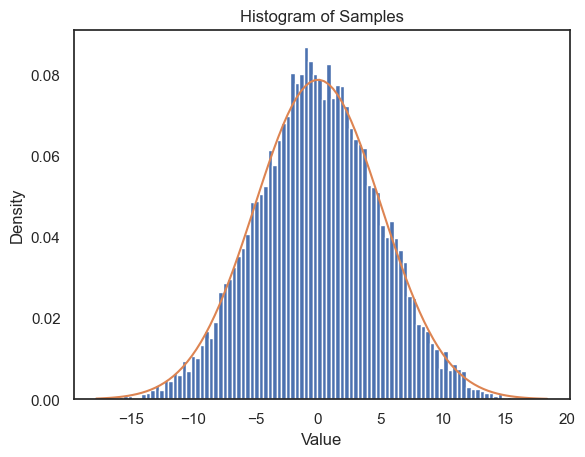

In [257]:
import time


def make_plot(P,t):
    log_f, xi, analytic_solution = run_simulation(P,t)

    num_steps = 10000
    def transform(state, info):
        x = state.position
        return xi(x)


    rng_key = jax.random.PRNGKey(1)

    sample_key, rng_key = jax.random.split(rng_key)
    tic = time.time()
    samples, initial_state, params, chain_key = run_mclmc(
        logdensity_fn=log_f,
        num_steps=num_steps,
        initial_position=jax.random.normal(sample_key, (P-1,)),
        key=rng_key,
        transform=transform,
        # desired_energy_variance=0.0005
    )
    toc = time.time()
    print("Time taken: ", toc - tic)
    samples.mean()

    import matplotlib.pyplot as plt

    plt.xlabel('Value')
    plt.ylabel('Density')
    l = np.linspace(jnp.min(samples), jnp.max(samples), 100)
    solution = analytic_solution(l)

    plt.hist(samples, bins=100, density=True)
    plt.plot(l, solution)
    plt.title('Histogram of Samples')
    plt.show()

make_plot(400, t=100.0)

In [274]:
import time

def get_samples(P, t, num_steps = 50000, i = 1, seed=0):
    log_f, xi, analytic_solution = run_simulation(P, t, seed=seed)

    
    def transform(state, info):
        x = state.position
        return (xi(x),x[i])


    rng_key = jax.random.PRNGKey(2)

    sample_key, rng_key = jax.random.split(rng_key)
    samples, initial_state, params, chain_key = run_mclmc(
        logdensity_fn=log_f,
        num_steps=num_steps,
        initial_position=jax.random.normal(sample_key, (P-1,)),
        key=rng_key,
        transform=transform,
        # desired_energy_variance=0.0005
    )
    return np.array(samples)

def rho(lam, t, P, i=1, seed=0): 

    M,Minv, K, alpha, gamma, r = make_M_Minv_K(P, t, seed=seed)
   
   
    return (1/ (2*np.sqrt(2*np.pi))) *2*(np.sum([Minv[1,j]*K[j] for j in range(1, K.shape[0]-1)]))*((1/(K @ Minv @ K))**(3/2))*lam*np.exp( (-(lam**2)) / (2 * K @ Minv @ K) )

    # return (1/ (2*np.sqrt(2*np.pi)) ) * 2*(np.sum([Minv[i,j]*K[j] for j in range(1, K.shape[0]-1)]))*((1/(K @ Minv @ K))**(3/2))*lam*np.exp( (-(lam**2)) / (2 * K @ Minv @ K) )


In [262]:
P = 32
i = 1
t = 1

samples, weights = get_samples(P=P, t=t, num_steps=100000, i = 1, seed=1)



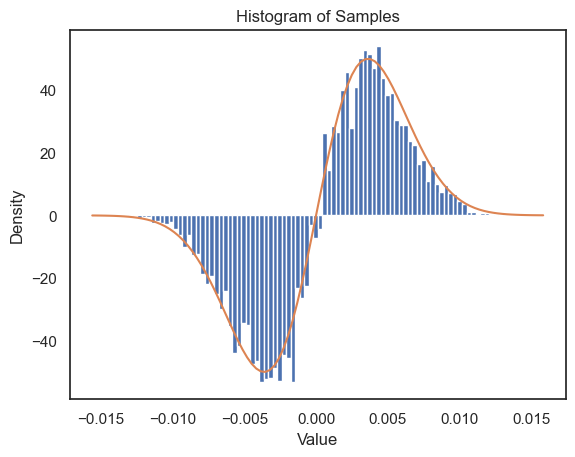

-1.5791001

In [276]:
plt.xlabel('Value')
plt.ylabel('Density')

hist, edges = np.histogram(samples, bins=100)
np.sum(hist*edges[1:])

normalization_constant = np.sum((edges[1:] - edges[:-1])*hist)

l = np.linspace(jnp.min(samples), jnp.max(samples), 100)
# l = np.linspace(-60, 60, 100)
solution = rho(lam=l, t=1, P=P, i = 1, seed=1)

# plt.hist(samples, bins=100, density=False,)
# plt.hist(samples, bins=100, density=False,)
# plt.show()
plt.hist(samples, bins=100, density=False, weights=weights/normalization_constant)
# plt.hist(samples, bins=100, density=False, weights=np.ones(samples.shape[0])/normalization_constant)
# plt.hist(samples, bins=100, density=False, weights=weights)
plt.plot(l, solution)
plt.title('Histogram of Samples')
plt.show()
np.sum(samples)

In [249]:
hist, edges = np.histogram(samples, bins=100)
np.sum(hist*edges[1:])

normalization_constant = np.sum((edges[1:] - edges[:-1])*hist)
normalization_constant

2.951251149730524

0.29315126 foo


Time taken:  2.850154161453247


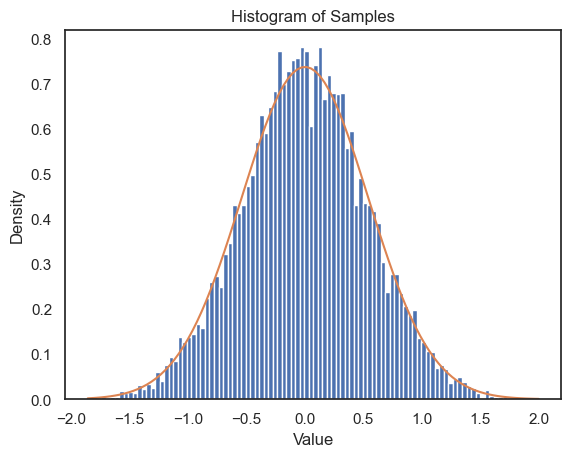

In [255]:
make_plot(400, t=10.0)

0.0 foo


2.9357383e-05 foo


0.00011742959 foo


0.00026421645 foo


0.00046971737 foo


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to 

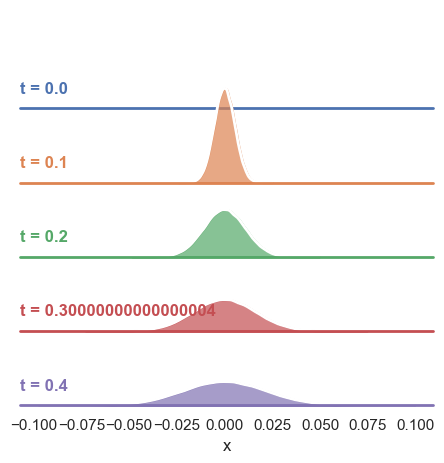

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate data for multiple Gaussians
np.random.seed(42)
num_gaussians = 5
data = []
for i in range(num_gaussians):
    mean = i * 2
    std_dev = 0.5
    x = get_samples(400, t=0.1*i)
    df = pd.DataFrame({'x': x, 'Gaussian': f't = {0.1*i}'})
    data.append(df)

data = pd.concat(data)

# Create the ridge plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
g = sns.FacetGrid(data, row="Gaussian", hue="Gaussian", aspect=5, height=1)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", fill=True, alpha=0.7, lw=1.5, clip_on=False)
g.map(sns.kdeplot, "x", color="w", lw=2, clip_on=False)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()

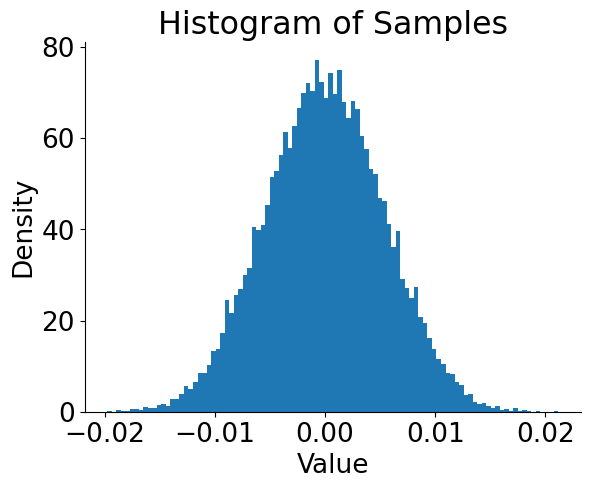

In [157]:
make_plot(400)


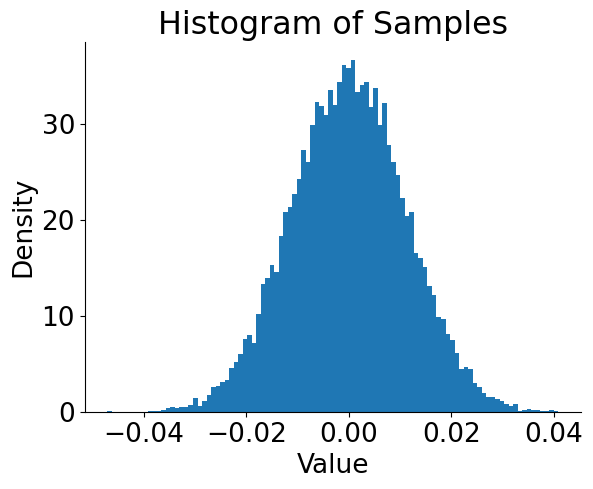

In [158]:
make_plot(800)